In [4]:
import torch
import torch.nn as nn
torch.cuda.empty_cache()

In [5]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.0.0
**********
_CUDA version: 
**********
CUDNN version: 8700


'nvcc' is not recognized as an internal or external command,
operable program or batch file.


Available GPU devices: 1
Device Name: Quadro P2000


# Model architecture

In [6]:
# Basic block for ResNet
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
    
# ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=1)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1)
        
        self.last_layer = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=3, padding=1, stride=2)


    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.last_layer(x)

        return x
    
def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [5]:
# Example usage
model = resnet18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          36,864
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8         [-1, 64, 112, 112]          36,864
       BatchNorm2d-9         [-1, 64, 112, 112]             128
             ReLU-10         [-1, 64, 112, 112]               0
       BasicBlock-11         [-1, 64, 112, 112]               0
           Conv2d-12         [-1, 64, 112, 112]          36,864
      BatchNorm2d-13         [-1, 64, 112, 112]             128
             ReLU-14         [-1, 64, 1

# Prepare dataset

In [7]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([transforms.Resize((224,224)),
                                # transforms.Grayscale(),                                
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                                ])

dataset = torchvision.datasets.ImageFolder(r'C:\Users\me1kox\OneDrive - AMRC\Documents\Training and trials codespace\FCDD anomaly detection Python\wood\processed', transform=transform)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


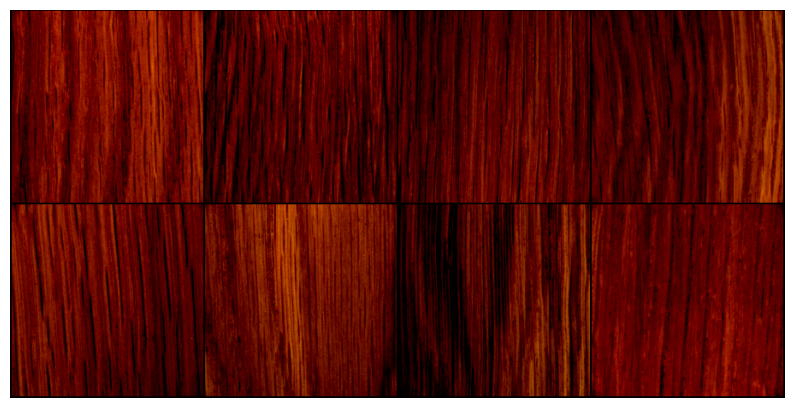

tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

# Run this to test your data loader
images, labels = next(iter(dataloader))

# Create a grid of images
grid = torchvision.utils.make_grid(images, nrow=4)

# Convert the tensor to a numpy array
grid_np = grid.permute(1, 2, 0).numpy()

# Display the grid of images
fig = plt.figure(figsize=(10, 8))
plt.imshow(grid_np)
plt.axis('off')
plt.show()
print(labels)

In [9]:
from torch.utils.data import Dataset, DataLoader, random_split

# Split the dataset into training and test sets
# train_size = int(0.9 * len(dataset))  # Use 80% of the data for training
# test_size = len(dataset) - train_size

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Send dataset to the GPU
# train_dataset, test_dataset = train_dataset.to(device), test_dataset.to(device)

train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# HSC loss function definition

In [10]:
from torch import Tensor

def loss(outs: Tensor, ins: Tensor, labels: Tensor, reduce: str='mean'):
    """ computes the FCDD loss """
    assert reduce in ['mean', 'none']
    loss = __fcdd_loss(outs, ins, labels, reduce)
    
    return loss
    
def __fcdd_loss(outs: Tensor, ins: Tensor, labels: Tensor, reduce: str):
        loss = outs ** 2
        loss = (loss + 1).sqrt() - 1
        loss = __supervised_loss(loss, labels)
        return loss.mean() if reduce == 'mean' else loss

def __supervised_loss(loss: Tensor, labels: Tensor):
    loss = loss.reshape(labels.size(0), -1).mean(-1)
    norm = loss[labels == 0]
    anom = (-(((1 - (-loss[labels == 1]).exp()) + 1e-31).log()))
    loss[(1-labels).nonzero().squeeze()] = norm
    loss[labels.nonzero().squeeze()] = anom
    
    return loss

# Train and test function definition

In [11]:
def train(model, train_loader, opt, loss_fn, scheduler, epochs: int, summary_writer, acc_batches=1):
        """
        In addition to the base class this train method support ground-truth maps, logs losses for
        nominal and anomalous samples separately, and introduces another parameter to
        accumulate batches for faster data loading.
        :param model: network to be trained
        :param epochs: number of full data loader iterations to train.
        :param acc_batches: To speed up data loading, this determines the number of batches that are accumulated
            before forwarded through the network. For instance, acc_batches=2 iterates the data loader two times,
            concatenates the batches, and passes this to the network. This has no impact on the performance
            if the batch size is reduced accordingly (e.g. one half in this example), but can decrease training time.
        :return: the trained network
        """
        assert 0 < acc_batches and isinstance(acc_batches, int)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        
        for epoch in range(epochs):
            running_loss = 0.0
            acc_data, acc_counter = [], 1
            for n_batch, data in enumerate(train_loader):
                if acc_counter < acc_batches and n_batch < len(train_loader) - 1:
                    acc_data.append(data)
                    acc_counter += 1
                    continue
                elif acc_batches > 1:
                    acc_data.append(data)
                    data = [torch.cat(d) for d in zip(*acc_data)]
                    acc_data, acc_counter = [], 1

                inputs, labels = data
                # gtmaps = None
                
                inputs = inputs.to(device)
                opt.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, inputs, labels)
                summary_writer.add_scalar("Loss/train", loss, epoch)
                loss.backward()
                opt.step()
                # Print statistics
                running_loss += loss.item()
                if n_batch % 5 == 0:
                    print(f"[Epoch {epoch + 1}, Batch {n_batch + 1}] Loss: {running_loss / 5:.3f}")
                    running_loss = 0.0
            
            # Update learning rate at the end of each epoch    
            scheduler.step()
        return model


# Train the model

In [12]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
torch.cuda.empty_cache()

criterion = loss
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.985)

In [13]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [14]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  43729 KiB |  43729 KiB |  43729 KiB |      0 B   |\n|       from large pool |  40320 KiB |  40320 KiB |  40320 KiB |      0 B   |\n|       from small pool |   3409 KiB |   3409 KiB |   3409 KiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |  43729 KiB |  43729 KiB |  43729 KiB |      0 B   |\n|       from large pool |  40320 KiB |  40320 KiB |

In [15]:
model_trained = train(model, train_loader, optimizer, criterion, scheduler, 200, writer)
writer.flush()

[Epoch 1, Batch 1] Loss: 0.029
[Epoch 1, Batch 6] Loss: 0.133
[Epoch 1, Batch 11] Loss: 0.112
[Epoch 1, Batch 16] Loss: 0.097
[Epoch 1, Batch 21] Loss: 0.083
[Epoch 1, Batch 26] Loss: 0.072
[Epoch 1, Batch 31] Loss: 0.063
[Epoch 1, Batch 36] Loss: 0.056
[Epoch 1, Batch 41] Loss: 0.050
[Epoch 1, Batch 46] Loss: 0.046
[Epoch 2, Batch 1] Loss: 0.009
[Epoch 2, Batch 6] Loss: 0.039
[Epoch 2, Batch 11] Loss: 0.036
[Epoch 2, Batch 16] Loss: 0.033
[Epoch 2, Batch 21] Loss: 0.031
[Epoch 2, Batch 26] Loss: 0.028
[Epoch 2, Batch 31] Loss: 0.027
[Epoch 2, Batch 36] Loss: 0.025
[Epoch 2, Batch 41] Loss: 0.023
[Epoch 2, Batch 46] Loss: 0.022
[Epoch 3, Batch 1] Loss: 0.004
[Epoch 3, Batch 6] Loss: 0.020
[Epoch 3, Batch 11] Loss: 0.019
[Epoch 3, Batch 16] Loss: 0.018
[Epoch 3, Batch 21] Loss: 0.017
[Epoch 3, Batch 26] Loss: 0.016
[Epoch 3, Batch 31] Loss: 0.015
[Epoch 3, Batch 36] Loss: 0.014
[Epoch 3, Batch 41] Loss: 0.014
[Epoch 3, Batch 46] Loss: 0.013
[Epoch 4, Batch 1] Loss: 0.002
[Epoch 4, Batch

KeyboardInterrupt: 

# Saving the model

In [16]:
from datetime import datetime

# Get the current system date and time
current_datetime = datetime.now()
Year = str(current_datetime.year)
Month = str(current_datetime.month)
Day = str(current_datetime.day)
Hour = str(current_datetime.hour)
Minute = str(current_datetime.minute)
Second = str(current_datetime.second)
Microsecond = str(current_datetime.microsecond)

In [17]:
PATH = r'Models\wood_model_'+ Day + Month + Year + '_' + Hour + Minute + '.pt'
torch.save(model.state_dict(), PATH)

# Loading model

In [7]:
model_loaded = resnet18()

PATH = r'Models\wood_model_1282023_1147.pt'

model_loaded.load_state_dict(torch.load(PATH))
model_loaded.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Inference

In [8]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [92]:
model = model_loaded
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

transform = transforms.Compose([transforms.Resize((224,224)),
                                # transforms.Grayscale(),                                
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                                ])

In [93]:
folder_path = r'wood\test\hole'

file_list = [filename for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))]

In [94]:
IMAGE_NO = 2

image_path = os.path.join(folder_path, file_list[IMAGE_NO])
image = Image.open(image_path)
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)


In [95]:
defect_map = output
defect_map = np.abs(defect_map[0].cpu().numpy().transpose(1, 2, 0))
defect_map = np.where(defect_map > 0.6, defect_map, 0.0)

x = np.max(defect_map)
y = np.min(defect_map)
print(x)

0.6443019


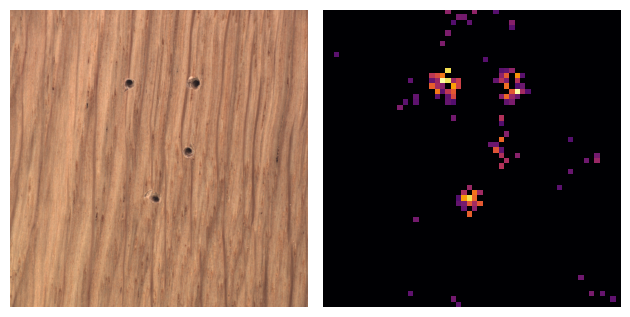

In [100]:
activation_threshold = 0.12

image = np.array(image)
# Transpose the tensor from (channels, height, width) to (height, width, channels)
# image = image.transpose(1, 2, 0)

defect_map = output
defect_map = np.abs(defect_map[0].cpu().numpy().transpose(1, 2, 0))
defect_map = np.where(defect_map > activation_threshold, defect_map, 0.0)

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2)

# Display the first image in the first subplot
axs[0].imshow(image)
axs[0].axis('off')  # Remove axis ticks and labels for the first subplot

# Display the second image in the second subplot
axs[1].imshow(defect_map, alpha=1, cmap='inferno', vmin=-0, vmax=0.5)
axs[1].axis('off')  # Remove axis ticks and labels for the second subplot

# Adjust the layout to avoid overlap of subplots
plt.tight_layout()

# Show the plot
plt.show()

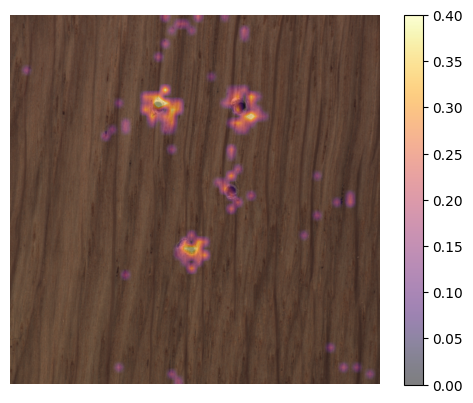

In [101]:
import cv2

# Display the first image in the first subplot
plt.imshow(image)

# Display the second image in the second subplot
defect_map2 = cv2.resize(defect_map, (1024,1024))
plt.imshow(defect_map2, alpha=0.5, cmap='inferno', vmin=-0, vmax=0.4)
plt.axis('off')  # Remove axis ticks and labels for the second subplot
plt.colorbar()

# Show the plot
plt.show()